<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Ali Ghelichkhani
### Student Number : 
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torch.optim as optim
import time
import copy

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=16, 
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(valid_data, 
                                          batch_size=16, 
                                          shuffle=True)                                              

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [15]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()

        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.seq2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.seq3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.seq4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.seq5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 10),
            # nn.ReLU(),
            # change based on a quera discuss
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x1 = self.seq1(x)
        x2 = self.seq2(x1)
        x3 = x1 + x2
        x4 = self.seq3(x3)
        x5 = self.seq4(x4)
        x6 = x4 + x5
        x7 = self.seq5(x6)
        return x7

# Train Model (30 Points)

In [16]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [17]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [19]:
dataloaders = dict(train=train_loader, val=val_loader)
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=10, log_interval=1)

Epoch 1/10
----------
train Loss: 1.5047 Acc: 95.64%
val Loss: 1.5261 Acc: 93.53%

Epoch 2/10
----------
train Loss: 1.5012 Acc: 95.99%
val Loss: 1.4865 Acc: 97.45%

Epoch 3/10
----------
train Loss: 1.4976 Acc: 96.36%
val Loss: 1.4942 Acc: 96.66%

Epoch 4/10
----------
train Loss: 1.4976 Acc: 96.35%
val Loss: 1.4992 Acc: 96.20%

Epoch 5/10
----------
train Loss: 1.4950 Acc: 96.61%
val Loss: 1.4919 Acc: 96.96%

Epoch 6/10
----------
train Loss: 1.4985 Acc: 96.24%
val Loss: 1.4947 Acc: 96.64%

Epoch 7/10
----------
train Loss: 1.5010 Acc: 96.01%
val Loss: 1.5064 Acc: 95.47%

Epoch 8/10
----------
train Loss: 1.4993 Acc: 96.18%
val Loss: 1.4852 Acc: 97.59%

Epoch 9/10
----------
train Loss: 1.5076 Acc: 95.35%
val Loss: 1.4870 Acc: 97.40%

Epoch 10/10
----------
train Loss: 1.5059 Acc: 95.52%
val Loss: 1.5027 Acc: 95.84%

Training complete in 4m 14s
Best val Acc: 97.59%


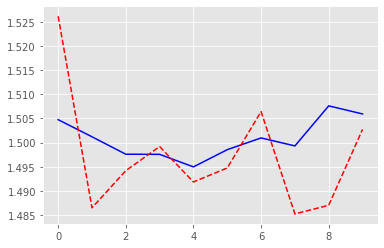

In [20]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
_ = plt.plot(losses['train'], '-b', losses['val'], '--r',)

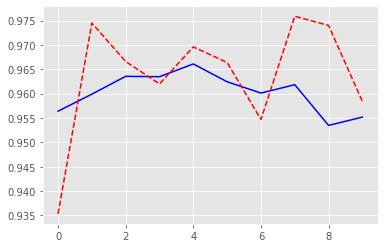

In [21]:
accuracies_train = []
accuracies_val = []

for i in accuracies['train']:
  accuracies_train.append(i.cpu())

for i in accuracies['val']:
  accuracies_val.append(i.cpu())

_ = plt.plot(accuracies_train, '-b', accuracies_val, '--r')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


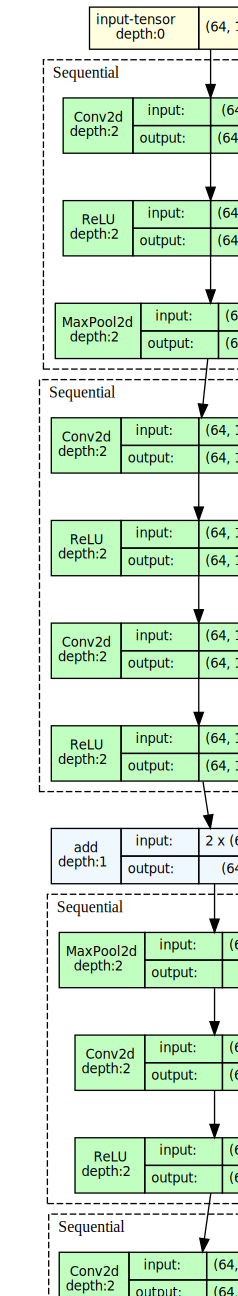

In [23]:
# %pip install torchview
# %pip install graphviz

import torchvision
import graphviz
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(64,1,28,28), expand_nested=True)
model_graph.visual_graph

# Test Model (20 Points)

In [24]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

def predict(classifier, dataloader):
  with torch.no_grad():
    model.eval()
    N = 0
    tot_loss, correct = 0.0, 0.0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        N += images.shape[0]
        tot_loss += images.shape[0] * criterion(outputs, labels).item()

        predicted_targets = outputs.argmax(dim=1)
        correct += (predicted_targets == labels).sum().item()
        
    print(" Test       : Loss : {:.4f}, Acc : {:.4f}".format(tot_loss/N, correct/N))
    return labels, predicted_targets

10000


In [25]:
results = predict(model, test_loader)

 Test       : Loss : 1.4852, Acc : 0.9759


In [26]:
from sklearn.metrics import classification_report

labels, predictions = results[0].cpu().numpy(), results[1].cpu().numpy()
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

